<a href="https://colab.research.google.com/github/Vinoth-24/NLP/blob/main/Bert_implementation_for_spam_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow_hub

In [ ]:
pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 462 kB 68.0 MB/s 


In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
#reading dataset
path="/content/drive/MyDrive/Colab Files/spam.csv"
df=pd.read_csv(path,encoding='ISO-8859-1')

In [14]:
df.head(5)

,Category,Message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [16]:
df = df[["Category", "Message"]]

In [18]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [20]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [21]:
747/4825

0.15481865284974095

In [22]:
###15% spam emails, 85% ham emails: This indicates class imbalance

In [23]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [24]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [25]:
(4825, 2)
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [26]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [27]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [28]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
994,ham,"I can't, I don't have her number!",0
1373,spam,"Bears Pic Nick, and Tom, Pete and ... Dick. In...",1
1435,ham,Dad went out oredi...,0
470,spam,okmail: Dear Dave this is your final notice to...,1
2373,spam,XMAS Prize draws! We are trying to contact U. ...,1


In [29]:
# Splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [30]:
## Now lets import BERT model and get embeding vectors for few sample statements
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [31]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.51327276, -0.88845724, ..., -0.74748844,
        -0.7531474 ,  0.91964495],
       [-0.87208337, -0.5054394 , -0.94446665, ..., -0.85847497,
        -0.71745324,  0.8808295 ]], dtype=float32)>

In [32]:
# Get embeding vectors for few sample words. Compare them using cosine similarity
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[2]])

array([[0.99540985]], dtype=float32)

In [36]:
# Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [37]:
# Building Functional Model

In [38]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [40]:
len(X_train)

1120

In [41]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [42]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 21s 304ms/step - loss: 0.6693 - accuracy: 0.6125 - precision: 0.6184 - recall: 0.5875
Epoch 2/10
35/35 [==============================] - 11s 306ms/step - loss: 0.5204 - accuracy: 0.8214 - precision: 0.8000 - recall: 0.8571
Epoch 3/10
35/35 [==============================] - 11s 325ms/step - loss: 0.4510 - accuracy: 0.8482 - precision: 0.8362 - recall: 0.8661
Epoch 4/10
35/35 [==============================] - 11s 311ms/step - loss: 0.4031 - accuracy: 0.8687 - precision: 0.8591 - recall: 0.8821
Epoch 5/10
35/35 [==============================] - 11s 313ms/step - loss: 0.3588 - accuracy: 0.8884 - precision: 0.8809 - recall: 0.8982
Epoch 6/10
35/35 [==============================] - 11s 318ms/step - loss: 0.3429 - accuracy: 0.8866 - precision: 0.8639 - recall: 0.9179
Epoch 7/10
35/35 [==============================] - 11s 314ms/step - loss: 0.3286 - accuracy: 0.8875 - precision: 0.8820 - recall: 0.8946
Epoch 8/10
35/35 [================

In [43]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 6s 338ms/step - loss: 0.2795 - accuracy: 0.9171 - precision: 0.9149 - recall: 0.9198


[0.27952367067337036,
 0.9171122908592224,
 0.914893627166748,
 0.9197860956192017]

In [44]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [45]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,

In [46]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[171,  16],
       [ 15, 172]])

Text(33.0, 0.5, 'Truth')

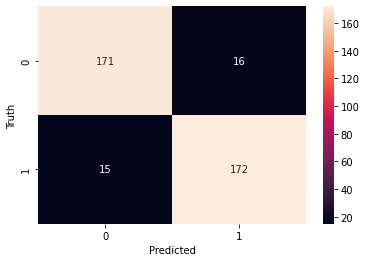

In [47]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [48]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       187
           1       0.91      0.92      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



In [49]:
# Inferance

In [50]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.69851434],
       [0.76054615],
       [0.7156118 ],
       [0.16878007],
       [0.08769186]], dtype=float32)

In [ ]:
# Prediction successful